In [1]:
import torch.nn as nn
import torch
from models_multiview import FrontaliseModelMasks_wider

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision.transforms import CenterCrop, Resize, Compose, ToTensor

In [15]:
MODEL_PATH = '/scratch/shared/slow/ow/faces_bmvc/models_to_share/' # Update with your path to the model files

Predicting landmarks for the given images on MAFL. Here we give a demo for a selection of random images.

(32, 256)


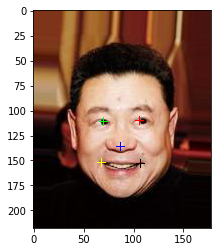

In [16]:
# Parameters:
inner_nc = 256; num_classes = 10; num_additional_ids=32
classifier_model = MODEL_PATH + '/release/aflw_4views.pth'

# Load the model and classifier weights
classifier = nn.Sequential(nn.BatchNorm1d(inner_nc), nn.Linear(inner_nc, num_classes, bias=False))
model = FrontaliseModelMasks_wider(3, inner_nc=inner_nc, num_additional_ids=num_additional_ids)

classifier.load_state_dict(torch.load(classifier_model)['state_dict'])
model.load_state_dict(torch.load(classifier_model)['state_dict_model'])
classifier.eval()
model.eval()

# Load the image from MAFL and perform cropping to make more like VoxCeleb
img = Image.open('./examples/mafl/031184.jpg').convert('RGB') # More in the examples folder, or download the full dataset
orig_image = img
OFFSET = 35
CROP = 35
IMAGE_SIZE = (256,256)
img = img.crop((0,CROP,img.size[0], img.size[1]))
size = (img.size[0]-OFFSET*2, img.size[1]-OFFSET*2)

transform = Compose([CenterCrop((size[1], size[0])), Resize(IMAGE_SIZE), ToTensor()])

# Predicted landmarks
xc = model.encoder(transform(img).unsqueeze(0))
landmarks = classifier(xc.squeeze().unsqueeze(0))
landmarks = landmarks.view(-1,2) 

# Convert to image locations
offsetx = size[0]
offsety = size[1]
addx = OFFSET
addy = OFFSET+CROP
landmarks[:,0] = (landmarks[:,0] + 1) * offsetx / 2. + addx
landmarks[:,1] = (landmarks[:,1] + 1) * offsety / 2. + addy
        
# Visualise landmarks
draw = ImageDraw.Draw(orig_image)
colors = [(0,256,0), (256,0,0), (0,0,256), (256,256,0), (0,0,0)]
for img_index_i in range(0, 5):
    draw.line([landmarks[img_index_i,0], landmarks[img_index_i,1]-4, landmarks[img_index_i,0], landmarks[img_index_i,1]+4], fill=colors[img_index_i % 5])
    draw.line([landmarks[img_index_i,0]-4, landmarks[img_index_i,1], landmarks[img_index_i,0]+4, landmarks[img_index_i,1]], fill=colors[img_index_i % 5])
    
plt.imshow(orig_image)

Predicting landmarks for the given images on 300W. Here we give a demo for a selection of random images.

(32, 256)


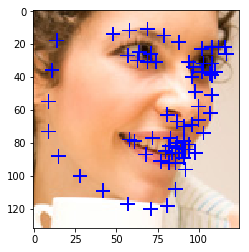

In [17]:
# Parameters:
import numpy as np
inner_nc = 256; num_classes = 136; num_additional_ids=32
classifier_model = MODEL_PATH + '/release/300w_4views.pt'

# Load the model and classifier weights
classifier = nn.Sequential(nn.BatchNorm1d(inner_nc), nn.Linear(inner_nc, num_classes, bias=False))
model = FrontaliseModelMasks_wider(3, inner_nc=inner_nc, num_additional_ids=num_additional_ids)

classifier.load_state_dict(torch.load(classifier_model)['state_dict'])
model.load_state_dict(torch.load(classifier_model)['state_dict_model'])
classifier.eval()
model.eval()

# Load the image from 300W and perform cropping to make more like VoxCeleb
img = Image.open('./examples/300w/ibug_image_99.jpg').convert('RGB') # Download the full dataset for more examples
bbox = np.array([312.4117, 57.3576, 416.5690, 166.9425])

# Crop and resize again to make more VoxCeleb
orig_image = img
OFFSET = (bbox[2:] - bbox[0:2])*0.1
OFFSET = [-int(OFFSET[0]+0.5), -int(OFFSET[1] + 0.5)]
img = img.crop((bbox[0]+OFFSET[0], bbox[1]+OFFSET[1], bbox[2]-OFFSET[0], bbox[3]-OFFSET[1]))
size = (img.size[0], img.size[1])

transform = Compose([Resize((256, 256)), ToTensor()])
OFFSET = bbox[0:2] + OFFSET # OFFSET 10+5 w/ 1000 examples = 8.88; 10+10=8.2, 10+15=7.5
size = (img.size[0], img.size[1])

# Predicted landmarks
xc = model.encoder(transform(img).unsqueeze(0))
landmarks = classifier(xc.squeeze().unsqueeze(0))
landmarks = landmarks.view(-1,2) 

# Convert to image locations
offsetx = size[0]
offsety = size[1]
addx = OFFSET[0]
addy = OFFSET[1]
landmarks[:,0] = (landmarks[:,0] + 1) * offsetx / 2. + addx
landmarks[:,1] = (landmarks[:,1] + 1) * offsety / 2. + addy
        
# Visualise landmarks
draw = ImageDraw.Draw(orig_image)
colors = [(0,0,256)]
for img_index_i in range(0, 68):
    draw.line([landmarks[img_index_i,0], landmarks[img_index_i,1]-4, landmarks[img_index_i,0], landmarks[img_index_i,1]+4], fill=colors[0 % 5])
    draw.line([landmarks[img_index_i,0]-4, landmarks[img_index_i,1], landmarks[img_index_i,0]+4, landmarks[img_index_i,1]], fill=colors[0 % 5])

    
OFFSET = (bbox[2:] - bbox[0:2])*0.1
OFFSET = [-int(OFFSET[0]+0.5), -int(OFFSET[1] + 0.5)]
orig_image = orig_image.crop((bbox[0]+OFFSET[0], bbox[1]+OFFSET[1], bbox[2]-OFFSET[0], bbox[3]-OFFSET[1]))
plt.imshow(orig_image)

And now show how we can predict emotion.

(32, 256)
Probabilities: 
 Neutral 0.1699 
 Happy 0.0837 
 Sad 0.1270 
 Surprise 0.1907 
 Fear 0.1915 
 Disgust 0.0599 
 Anger 0.0967

 With probability 0.191469, predicted emotion Fear.


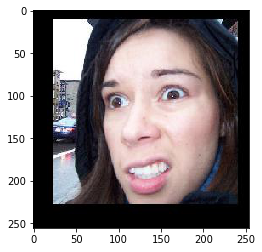

In [18]:
# Parameters:
import numpy as np
inner_nc = 256; num_classes = 8; num_additional_ids=32
classifier_model = MODEL_PATH + '/release/affectnet_4views.pth'

# Load the model and classifier weights
classifier = nn.Sequential(nn.BatchNorm1d(inner_nc), nn.Linear(inner_nc, num_classes, bias=False))
model = FrontaliseModelMasks_wider(3, inner_nc=inner_nc, num_additional_ids=num_additional_ids)

classifier.load_state_dict(torch.load(classifier_model)['state_dict'])
model.load_state_dict(torch.load(classifier_model)['state_dict_model'])
classifier.eval()
model.eval()

# Load image from affectnet 
img = './examples/affectnet/991_7803ea5b854f9d35db61a9afe2a3fc834894ca2a861af2ce151b206e.jpg'
img = Image.open(img).convert('RGB')
transform = Compose([Resize((256, 256)) ,ToTensor()])

# Predicted emotion
xc = model.encoder(transform(img).unsqueeze(0))
probabilities = nn.Sigmoid()(classifier(xc.squeeze().unsqueeze(0)))
probabilities = probabilities[0] / probabilities.sum()
prediction = probabilities.max(0)

emotions = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']

plt.imshow(img)
print("Probabilities: \n {} {:0.4f} \n {} {:0.4f} \n {} {:0.4f} \n {} {:0.4f} \n {} {:0.4f} \n {} {:0.4f} \n {} {:0.4f}".format(
                                                emotions[0], probabilities[0].cpu().item(),
                                                emotions[1], probabilities[1].cpu().item(),
                                                emotions[2], probabilities[2].cpu().item(),
                                                emotions[3], probabilities[3].cpu().item(),
                                                emotions[4], probabilities[4].cpu().item(),
                                                emotions[5], probabilities[5].cpu().item(),
                                                emotions[6], probabilities[6].cpu().item(),
                                                emotions[7], probabilities[7].cpu().item()))

print('\n With probability %f, predicted emotion %s.' % (prediction[0].cpu().item(), emotions[prediction[1].item()]))


(32, 256)
Predicted head pose: roll 3.45, pitch -11.20, yaw -38.08
Ground truth head pose: roll 2.88, pitch -6.36, yaw -39.67


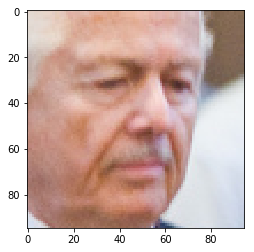

In [19]:
# Parameters:
import numpy as np
inner_nc = 256; num_classes = 3; num_additional_ids=32
classifier_model = MODEL_PATH + '/release/aflwpose_nv4.pth'


# Load the model and classifier weights
classifier = nn.Sequential(nn.BatchNorm1d(inner_nc), nn.Linear(inner_nc, num_classes, bias=False))
model = FrontaliseModelMasks_wider(3, inner_nc=inner_nc, num_additional_ids=num_additional_ids)

classifier.load_state_dict(torch.load(classifier_model)['state_dict'])
model.load_state_dict(torch.load(classifier_model)['state_dict_model'])
classifier.eval()
model.eval()

# Load the image from the AFLW test set and perform cropping
img = Image.open('./examples/aflw/image66922.jpg').convert('RGB')
img = img.crop([237,228,332,323])

transform = Compose([Resize((256, 256)), ToTensor()])
# Predicted pose
xc = model.encoder(transform(img).unsqueeze(0))
pose = 180/np.pi * classifier(xc.squeeze().unsqueeze(0)).cpu().data.numpy()[0]
gtpose = 180/np.pi * np.array([0.05019387, -0.11107627, -0.6923566])

plt.imshow(img)
print('Predicted head pose: roll %.2f, pitch %.2f, yaw %.2f' %(pose[0], pose[1], pose[2]))
print('Ground truth head pose: roll %.2f, pitch %.2f, yaw %.2f' %(gtpose[0], gtpose[1], gtpose[2]))